In [1]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Step-1:** Import the dataset

In [2]:
df = pd.read_csv("/kaggle/input/housepricedataset/house_price_train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Step-2:** Handling the Null values in the dataset

In [3]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
#Drop the null values if you have more than 30% of Null

df.dropna(axis=1, thresh=0.7*len(df), inplace=True)

#Fill the null values
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


**Step-3:** Splitting the Dataset

In [6]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

**Step-4:** Applying Constant Feature

In [7]:
constant_feature = [col for col in X_train.columns if X_train[col].nunique == 1]
print(constant_feature)

[]


Step-5: Quasi Constant Feature

In [8]:
quasi_constant_feature = []
threshold = 0.98

for col in X_train.columns:
    freq = X_train[col].value_counts(normalize=True).iloc[0]
    if freq >= threshold:
        quasi_constant_feature.append(col)

print("quasi_constant_feature: ", quasi_constant_feature)

X_train = X_train.drop(columns=quasi_constant_feature, axis=1)
X_test = X_test.drop(columns=quasi_constant_feature, axis=1)

quasi_constant_feature:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


**Step-6:** Duplicate Features

In [9]:
train_T = X_train.T
duplicate_features = train_T[train_T.duplicated()].index.tolist()
print(duplicate_features)

X_train = X_train.drop(columns=duplicate_features, axis=1)
X_test = X_test.drop(columns=duplicate_features, axis=1)

[]


**Step-7:** Correlation

In [10]:
numerical_X_train = X_train.select_dtypes(include=['number'])
corr_matrix = numerical_X_train.corr()
corr_threshold = 0.98
corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j] > corr_threshold):
            corr_pairs.add(corr_matrix.columns[i])

print(corr_pairs)

set()


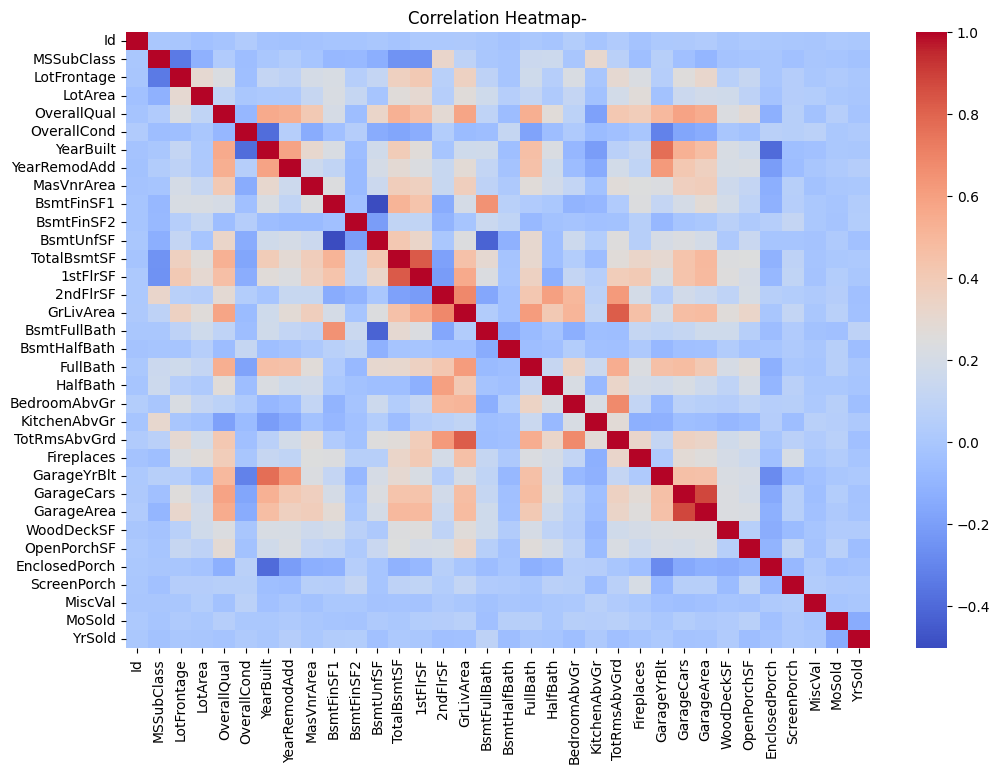

In [11]:
#Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap-")
plt.show()

**Step-8:** Mututal Information Regression

In [12]:
numerical_X_train = X_train.select_dtypes(include=['number'])

mi_scores = mutual_info_regression(numerical_X_train, y_train, discrete_features=False)
mi_df = pd.Series(mi_scores, index=numerical_X_train.columns)
mi_df = mi_df.sort_values(ascending=False)


low_importance = mi_df[mi_df < 0.01].index.tolist()

print(low_importance)

X_train = X_train.drop(columns=low_importance,axis=1)
X_test = X_test.drop(columns=low_importance, axis =1)

['YrSold', 'BsmtFinSF2', 'Id', 'MiscVal', 'MoSold', 'BsmtHalfBath']


In [13]:
#Chi Square cannot be applied since the output feature is numerical

In [14]:
from sklearn.feature_selection import f_regression
import pandas as pd

# 1. Select numerical features
X_num = X_train.select_dtypes(include='number')

# 2. Compute F-statistic and p-values
f_scores, p_values = f_regression(X_num, y_train)

# 3. Wrap into a DataFrame for better understanding
anova_df = pd.DataFrame({
    'F_Score': f_scores,
    'P_Value': p_values
}, index=X_num.columns)

# 4. Sort by F-score (descending)
anova_df = anova_df.sort_values(by='F_Score', ascending=False)

# 5. Optional: remove features with weak relationship (e.g., p-value > 0.05)
insignificant_features = anova_df[anova_df['P_Value'] > 0.05].index.tolist()

print("Dropping features with weak linear relationship:", insignificant_features)

# 6. Drop those from train and test
X_train = X_train.drop(columns=insignificant_features)
X_test = X_test.drop(columns=insignificant_features)


Dropping features with weak linear relationship: []
